In [1]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import os
import json
import shutil
import warnings
warnings.filterwarnings('ignore')
import csv
import traceback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import QuantileTransformer


In [2]:
# Create directories for storing results
results_dir = 'defense_results'
checkpoint_dir = 'defense_checkpoints'
for directory in [results_dir, checkpoint_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)


In [3]:
print("Task 2: Developing Adversarial Defense Mechanisms")

# Load data and models from previous tasks
print("Loading dataset and models from previous tasks...")

# Training data
train_features = scipy.io.loadmat("./IAPRTC/IAPRTC-12_TrainFeat.mat")
train_labels = scipy.io.loadmat("./IAPRTC/IAPRTC-12_TrainLabels.mat")
train_features = train_features['I_x_tr'][0][0]
train_labels = train_labels['I_z_tr'][0][0]

# Testing data
test_features = scipy.io.loadmat("./IAPRTC/IAPRTC-12_TestFeat.mat")
test_labels = scipy.io.loadmat("./IAPRTC/IAPRTC-12_TestLabels.mat")
test_features = test_features['I_x_te'][0][0]
test_labels = test_labels['I_z_te'][0][0]

print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")


Task 2: Developing Adversarial Defense Mechanisms
Loading dataset and models from previous tasks...
Train Features: (17665, 2048), Train Labels: (17665, 291)
Test Features: (1962, 2048), Test Labels: (1962, 291)


In [4]:
# Load scaler and PCA from Task 0
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca_model.pkl')
X_test_scaled = scaler.transform(test_features)
X_test_reduced = pca.transform(X_test_scaled)

# Dictionary to store loaded models
trained_models = {}

# Load models
model_files = {
    'Linear SVM': 'linear_svm.pkl',
    'Logistic Regression': 'logistic_regression.pkl',
    'Softmax Regression': 'softmax_regression.pkl',
    'Decision Tree': 'decision_tree.pkl',
    'Weighted KNN': 'weighted_knn.pkl'
}

for name, file in model_files.items():
    try:
        model = joblib.load(file)
        trained_models[name] = model
        print(f"Loaded {name} model")
    except Exception as e:
        print(f"Error loading {name} model: {e}")

Loaded Linear SVM model
Loaded Logistic Regression model
Loaded Softmax Regression model
Loaded Decision Tree model
Error loading Weighted KNN model: [Errno 2] No such file or directory: 'weighted_knn.pkl'


In [5]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name=None):
    """
    Evaluate a multilabel classification model using various metrics.
    Returns a dictionary of evaluation metrics.
    """
    if model_name == 'Weighted KNN':
        X_test_reduced = pca.transform(X_test)
        y_pred = model.predict(X_test_reduced)
    else:
        y_pred = model.predict(X_test)
    
    # For multilabel classification
    accuracy = accuracy_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    hamming = hamming_loss(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'hamming_loss': hamming
    }


In [6]:
# Load base model performance
base_df = pd.read_csv('base_model_performance.csv')
base_results = {}
for _, row in base_df.iterrows():
    base_results[row['Model']] = {
        'accuracy': row['Accuracy'],
        'precision_micro': row['Precision (micro)'],
        'recall_micro': row['Recall (micro)'],
        'f1_micro': row['F1 (micro)'],
        'hamming_loss': row['Hamming Loss']
    }


In [7]:
# FGSM attack function from Task 1
def fgsm_attack(model, X, y, epsilon=0.1, model_name=None, targeted=False, target_labels=None):
    """
    Fast Gradient Sign Method (FGSM) attack
    """
    X_adv = X.copy()
    batch_size = 100  # Process in smaller batches
    
    for start_idx in range(0, len(X), batch_size):
        end_idx = min(start_idx + batch_size, len(X))
        X_batch = X[start_idx:end_idx]
        
        # Numerical gradient estimation
        grad = np.zeros_like(X_batch)
        delta = 0.01
        
        print(f"Processing batch {start_idx//batch_size + 1}/{(len(X) + batch_size - 1)//batch_size}...")
        for i in range(X_batch.shape[1]):
            if i % 100 == 0:  # Print progress
                print(f"  Feature {i}/{X_batch.shape[1]}")
            
            X_plus = X_batch.copy()
            X_plus[:, i] += delta
            
            X_minus = X_batch.copy()
            X_minus[:, i] -= delta
            
            # Get predictions
            if model_name == 'Weighted KNN':
                X_plus_reduced = pca.transform(X_plus)
                y_plus = model.predict(X_plus_reduced)
                
                X_minus_reduced = pca.transform(X_minus)
                y_minus = model.predict(X_minus_reduced)
            else:
                y_plus = model.predict(X_plus)
                y_minus = model.predict(X_minus)
            
            # Calculate loss
            if targeted:
                # For targeted attack, we want to maximize similarity to target
                plus_loss = -np.mean((y_plus == target_labels[start_idx:end_idx]).astype(int))
                minus_loss = -np.mean((y_minus == target_labels[start_idx:end_idx]).astype(int))
            else:
                # For untargeted attack, we want to maximize difference from original
                plus_loss = -np.mean((y_plus != y[start_idx:end_idx]).astype(int))
                minus_loss = -np.mean((y_minus != y[start_idx:end_idx]).astype(int))
            
            # Gradient approximation
            grad[:, i] = (plus_loss - minus_loss) / (2 * delta)
        
        # Update adversarial examples
        adv_update = epsilon * np.sign(grad)
        X_adv[start_idx:end_idx] = X_batch + adv_update
    
    return X_adv


In [8]:
# Function to save defense results with proper error handling
def save_defense_results(results, filename):
    """Save defense results to CSV file with error handling"""
    filepath = os.path.join(results_dir, filename)
    try:
        # Check if file exists and has header
        file_exists = os.path.isfile(filepath)
        with open(filepath, 'a', newline='') as csvfile:
            fieldnames = ['timestamp', 'model_name', 'defense_type', 'attack_type', 'epsilon', 
                         'accuracy', 'precision_micro', 'recall_micro', 'f1_micro', 'base_f1_micro']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            if not file_exists:
                writer.writeheader()
            
            if isinstance(results, list):
                for row in results:
                    writer.writerow(row)
            else:
                writer.writerow(results)
        print(f"Results saved to {filepath}")
        return True
    except Exception as e:
        print(f"Error saving results to {filepath}: {e}")
        return False


In [9]:
# Function to check if defense has already been run
def check_defense_completed(defense_type, model_name, epsilon):
    """Check if a specific defense has already been run and saved"""
    for filename in os.listdir(results_dir):
        if filename.endswith('.csv') and defense_type.lower() in filename.lower():
            try:
                df = pd.read_csv(os.path.join(results_dir, filename))
                matching_rows = df[(df['model_name'] == model_name) & 
                                 (df['defense_type'] == defense_type) & 
                                 (df['epsilon'] == epsilon)]
                if not matching_rows.empty:
                    return True
            except Exception:
                pass
    return False

In [10]:
# Choose a subset of test data for evaluation
test_size = 100
np.random.seed(42)  # For reproducibility
indices = np.random.choice(test_features.shape[0], test_size, replace=False)
X_test_subset = X_test_scaled[indices]
y_test_subset = test_labels[indices]

# Set epsilon for attacks
epsilon = 0.5

In [11]:
# ----- 1. Adversarial Training -----

def adversarial_training(model, X_train, y_train, model_name=None, epsilon=0.1, ratio=0.5):
    """
    Train a model on a mix of original and adversarial examples
    
    Parameters:
    -----------
    model : trained model
        Base model to improve
    X_train : array-like
        Original training data
    y_train : array-like
        Original training labels
    model_name : str
        Name of the model
    epsilon : float
        Perturbation magnitude for adversarial examples
    ratio : float
        Ratio of adversarial examples to include in training
        
    Returns:
    --------
    Trained robust model
    """
    print(f"Performing adversarial training for {model_name}...")
    
    # Check if this model's adversarial training has been done
    checkpoint_file = os.path.join(checkpoint_dir, f"adv_train_{model_name.replace(' ', '_').lower()}.pkl")
    if os.path.exists(checkpoint_file):
        print(f"Loading pre-trained robust model for {model_name}...")
        try:
            robust_model = joblib.load(checkpoint_file)
            print(f"Loaded robust {model_name} from checkpoint")
            return robust_model
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Will retrain.")
    
    print(f"Performing adversarial training for {model_name}...")
    
    # Choose a subset of training data to generate adversarial examples
    train_size = int(min(1000, X_train.shape[0] * ratio))
    indices = np.random.choice(X_train.shape[0], train_size, replace=False)
    X_subset = X_train[indices]
    y_subset = y_train[indices]
    
    # Generate adversarial examples
    print(f"Generating {train_size} adversarial examples...")
    X_adv = fgsm_attack(model, X_subset, y_subset, epsilon=epsilon, model_name=model_name)
    
    # Combine original and adversarial examples
    X_combined = np.vstack((X_train, X_adv))
    y_combined = np.vstack((y_train, y_subset))
    
    try:
        # Create and train a new model of the same type
        if model_name == 'Linear SVM':
            robust_model = OneVsRestClassifier(LinearSVC(max_iter=1000))
        elif model_name == 'Logistic Regression':
            robust_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
        elif model_name == 'Softmax Regression':
            robust_model = OneVsRestClassifier(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
        elif model_name == 'Decision Tree':
            robust_model = OneVsRestClassifier(DecisionTreeClassifier(max_depth=5))
        elif model_name == 'Weighted KNN':
            robust_model = OneVsRestClassifier(KNeighborsClassifier(weights='distance', n_neighbors=5))
            if model_name == 'Weighted KNN':
                X_combined_reduced = pca.transform(X_combined)
                print(f"Training robust {model_name} on {X_combined_reduced.shape[0]} examples...")
                robust_model.fit(X_combined_reduced, y_combined)
                # Save checkpoint
                joblib.dump(robust_model, checkpoint_file)
                return robust_model
        
        print(f"Training robust {model_name} on {X_combined.shape[0]} examples...")
        robust_model.fit(X_combined, y_combined)
        
        # Save checkpoint
        joblib.dump(robust_model, checkpoint_file)
        return robust_model
    
    except Exception as e:
        print(f"Error during adversarial training for {model_name}: {e}")
        return None


In [12]:
# ----- 2. Feature Squeezing -----

def feature_squeezing(X, bit_depth=5):
    """
    Reduce the precision of input features to remove adversarial perturbations
    """
    # Check if we have a cached result
    cache_path = os.path.join(checkpoint_dir, f'feature_squeezed_{bit_depth}.joblib')
    
    if os.path.exists(cache_path) and X.shape == joblib.load(cache_path)['shape']:
        print(f"Loading cached feature squeezing result (bit_depth={bit_depth})")
        cached_data = joblib.load(cache_path)
        if cached_data['X'].shape == X.shape:
            return cached_data['X']
    
    print(f"Applying feature squeezing with bit_depth={bit_depth}...")
    
    # Normalize to [0, 1]
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_normalized = (X - X_min) / (X_max - X_min + 1e-10)
    
    # Quantize to specified bit depth
    levels = 2 ** bit_depth
    X_quantized = np.round(X_normalized * (levels - 1)) / (levels - 1)
    
    # Scale back to original range
    X_squeezed = X_quantized * (X_max - X_min) + X_min
    
    # Cache the result
    joblib.dump({'X': X_squeezed, 'shape': X.shape}, cache_path)
    
    return X_squeezed


In [13]:
# ----- 3. Gaussian Data Augmentation -----

def gaussian_augmentation(model, X_train, y_train, model_name=None, sigma=0.1, num_samples=1):
    """
    Train a model with Gaussian noise augmentation
    
    Parameters:
    -----------
    model : trained model
        Base model to improve
    X_train : array-like
        Original training data
    y_train : array-like
        Original training labels
    model_name : str
        Name of the model
    sigma : float
        Standard deviation of Gaussian noise
    num_samples : int
        Number of noisy samples per original sample
        
    Returns:
    --------
    Trained robust model
    """
    print(f"Performing Gaussian augmentation for {model_name}...")
    
    # Check if this model's gaussian augmentation has been done
    checkpoint_file = os.path.join(checkpoint_dir, f"gaussian_aug_{model_name.replace(' ', '_').lower()}.pkl")
    if os.path.exists(checkpoint_file):
        print(f"Loading pre-trained Gaussian-augmented model for {model_name}...")
        try:
            robust_model = joblib.load(checkpoint_file)
            print(f"Loaded Gaussian-augmented {model_name} from checkpoint")
            return robust_model
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Will retrain.")
    
    # Choose a subset of training data to generate augmented examples
    train_size = min(1000, X_train.shape[0])
    indices = np.random.choice(X_train.shape[0], train_size, replace=False)
    X_subset = X_train[indices]
    y_subset = y_train[indices]
    
    # Generate augmented examples with Gaussian noise
    X_augmented_list = [X_train]
    y_augmented_list = [y_train]
    
    for i in range(num_samples):
        print(f"Generating augmented set {i+1}/{num_samples}...")
        noise = np.random.normal(0, sigma, X_subset.shape)
        X_noisy = X_subset + noise
        X_augmented_list.append(X_noisy)
        y_augmented_list.append(y_subset)
    
    # Combine original and augmented examples
    X_combined = np.vstack(X_augmented_list)
    y_combined = np.vstack(y_augmented_list)
    
    try:
        # Create and train a new model of the same type
        if model_name == 'Linear SVM':
            robust_model = OneVsRestClassifier(LinearSVC(max_iter=1))
        elif model_name == 'Logistic Regression':
            robust_model = OneVsRestClassifier(LogisticRegression(max_iter=1, n_jobs=1))
        elif model_name == 'Softmax Regression':
            robust_model = OneVsRestClassifier(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1, n_jobs=1))
        elif model_name == 'Decision Tree':
            robust_model = OneVsRestClassifier(DecisionTreeClassifier(
            criterion='gini',  # 'gini' or 'entropy', default is 'gini'
            max_depth=5,  # Limit tree depth to prevent overfitting
            min_samples_split=5,  # Minimum samples to split a node
            min_samples_leaf=2,  # Minimum samples per leaf
            random_state=42  # Ensure reproducibility
        ))
        elif model_name == 'Weighted KNN':
            robust_model = OneVsRestClassifier(KNeighborsClassifier(
            weights='distance',  
            n_neighbors=5,  
            algorithm='auto',  # Automatically selects the best algorithm
            leaf_size=30,  # Affects speed, default is 30
            p=2,  # p=2 means Euclidean distance
            n_jobs=1  # Single-threaded execution
            ))
            if model_name == 'Weighted KNN':
                X_combined_reduced = pca.transform(X_combined)
                print(f"Training robust {model_name} on {X_combined_reduced.shape[0]} examples...")
                robust_model.fit(X_combined_reduced, y_combined)
                # Save checkpoint
                joblib.dump(robust_model, checkpoint_file)
                return robust_model
        
        print(f"Training robust {model_name} on {X_combined.shape[0]} examples...")
        robust_model.fit(X_combined, y_combined)
        
        # Save checkpoint
        joblib.dump(robust_model, checkpoint_file)
        return robust_model
    
    except Exception as e:
        print(f"Error during Gaussian augmentation training for {model_name}: {e}")
        return None

In [14]:
# ----- 4. Ensemble Method Defense -----

def ensemble_defense(models_dict, X, voting='soft'):
    """
    Create an ensemble of models for defense
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of trained models
    X : array-like
        Input features
    voting : str
        Voting strategy ('hard' or 'soft')
        
    Returns:
    --------
    y_ensemble : array-like
        Ensemble predictions
    """
    all_predictions = []
    
    for name, model in models_dict.items():
        try:
            if name == 'Weighted KNN':
                X_reduced = pca.transform(X)
                y_pred = model.predict(X_reduced)
            else:
                y_pred = model.predict(X)
            all_predictions.append(y_pred)
        except Exception as e:
            print(f"Error getting prediction from {name}: {e}")
    
    if not all_predictions:
        print("No valid predictions found for ensemble")
        return None
        
    all_predictions = np.array(all_predictions)
    
    if voting == 'hard':
        # Simple majority voting
        y_ensemble = np.mean(all_predictions, axis=0) >= 0.5
    else:  # soft voting - average probabilities
        y_ensemble = np.mean(all_predictions, axis=0) >= 0.5
    
    return y_ensemble.astype(int)

In [15]:
# ----- 5. Input Transformation Defense -----

def input_transformation_defense(X, method='scaling'):
    """
    Apply input transformations to defend against adversarial attacks
    
    Parameters:
    -----------
    X : array-like
        Input features
    method : str
        Transformation method ('scaling', 'pca', 'quantile')
        
    Returns:
    --------
    X_transformed : array-like
        Transformed features
    """
    try:
        # Check for cached transformers first
        transformer_file = os.path.join(checkpoint_dir, f"transformer_{method}.pkl")
        
        if os.path.exists(transformer_file):
            print(f"Loading pre-trained {method} transformer...")
            transformer = joblib.load(transformer_file)
            X_transformed = transformer.transform(X)
            
            # For PCA, we need to reconstruct after dimension reduction
            if method == 'pca':
                X_transformed = transformer.inverse_transform(X_transformed)
                
            return X_transformed
        
        # Train transformer if not cached
        if method == 'scaling':
            # Robust scaling less sensitive to outliers
            transformer = RobustScaler().fit(X)
            X_transformed = transformer.transform(X)
        elif method == 'pca':
            # PCA transformation can remove some adversarial noise
            transformer = PCA(n_components=min(X.shape[1], 200)).fit(X)
            X_transformed = transformer.transform(X)
            X_transformed = transformer.inverse_transform(X_transformed)
        elif method == 'quantile':
            # Quantile transformation can normalize the distribution
            transformer = QuantileTransformer(output_distribution='normal').fit(X)
            X_transformed = transformer.transform(X)
        else:
            raise ValueError(f"Unknown transformation method: {method}")
        
        # Save transformer for future use
        joblib.dump(transformer, transformer_file)
        
        return X_transformed
        
    except Exception as e:
        print(f"Error during input transformation ({method}): {e}")
        return X  # Return original input if transformation fails

In [16]:
# ----- Generate Adversarial Examples -----

def generate_adversarial_examples():
    """Generate adversarial examples for all models"""
    # Check if we have a checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, 'adversarial_examples.joblib')
    
    if os.path.exists(checkpoint_path):
        print("Loading adversarial examples from checkpoint...")
        return joblib.load(checkpoint_path)
    
    print("\nGenerating adversarial examples for all models...")
    attack_X_adv = {}
    
    for name, model in trained_models.items():
        print(f"\nGenerating adversarial examples against {name} with epsilon={epsilon}...")
        attack_X_adv[name] = fgsm_attack(model, X_test_subset, y_test_subset, epsilon=epsilon, model_name=name)
    
    # Save checkpoint
    joblib.dump(attack_X_adv, checkpoint_path)
    
    return attack_X_adv

attack_X_adv = generate_adversarial_examples()



Generating adversarial examples for all models...

Generating adversarial examples against Linear SVM with epsilon=0.5...
Processing batch 1/1...
  Feature 0/2048
  Feature 100/2048
  Feature 200/2048
  Feature 300/2048
  Feature 400/2048
  Feature 500/2048
  Feature 600/2048
  Feature 700/2048
  Feature 800/2048
  Feature 900/2048
  Feature 1000/2048
  Feature 1100/2048
  Feature 1200/2048
  Feature 1300/2048
  Feature 1400/2048
  Feature 1500/2048
  Feature 1600/2048
  Feature 1700/2048
  Feature 1800/2048
  Feature 1900/2048
  Feature 2000/2048

Generating adversarial examples against Logistic Regression with epsilon=0.5...
Processing batch 1/1...
  Feature 0/2048
  Feature 100/2048
  Feature 200/2048
  Feature 300/2048
  Feature 400/2048
  Feature 500/2048
  Feature 600/2048
  Feature 700/2048
  Feature 800/2048
  Feature 900/2048
  Feature 1000/2048
  Feature 1100/2048
  Feature 1200/2048
  Feature 1300/2048
  Feature 1400/2048
  Feature 1500/2048
  Feature 1600/2048
  Feature 17

In [17]:
# ----- Test Adversarial Training Defense -----

def test_adversarial_training():
    """Test adversarial training defense"""
    # Check if we have completed results already
    results_path = os.path.join(results_dir, 'adversarial_training_results.csv')
    if os.path.exists(results_path):
        print(f"Adversarial training results already exist at {results_path}")
        try:
            return pd.read_csv(results_path).to_dict('records')
        except:
            print("Error reading existing results, recomputing...")
    
    print("\n1. Testing Adversarial Training Defense")
    adv_training_results = []

    # Train robust models using adversarial training
    robust_models = {}
    for name, model in trained_models.items():
        if name not in ['Weighted KNN']:  # Skip KNN for efficiency
            robust_models[name] = adversarial_training(model, X_test_scaled[:1000], test_labels[:1000], 
                                                    model_name=name, epsilon=0.1, ratio=0.3)
            
            # Evaluate base model on clean data
            base_metrics_clean = evaluate_model(model, X_test_subset, y_test_subset, model_name=name)
            
            # Evaluate base model on adversarial data
            base_metrics_adv = evaluate_model(model, attack_X_adv[name], y_test_subset, model_name=name)
            
            # Evaluate robust model on clean data
            robust_metrics_clean = evaluate_model(robust_models[name], X_test_subset, y_test_subset, model_name=name)
            
            # Evaluate robust model on adversarial data
            robust_metrics_adv = evaluate_model(robust_models[name], attack_X_adv[name], y_test_subset, model_name=name)
            
            # Save results for base model on clean data
            adv_training_results.append({
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'model_name': name,
                'defense_type': 'none',
                'attack_type': 'none',
                'epsilon': 0.0,
                'accuracy': base_metrics_clean['accuracy'],
                'precision_micro': base_metrics_clean['precision_micro'],
                'recall_micro': base_metrics_clean['recall_micro'],
                'f1_micro': base_metrics_clean['f1_micro'],
                'base_f1_micro': base_metrics_clean['f1_micro']
            })
            
            # Save results for base model on adversarial data
            adv_training_results.append({
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'model_name': name,
                'defense_type': 'none',
                'attack_type': 'white-box',
                'epsilon': epsilon,
                'accuracy': base_metrics_adv['accuracy'],
                'precision_micro': base_metrics_adv['precision_micro'],
                'recall_micro': base_metrics_adv['recall_micro'],
                'f1_micro': base_metrics_adv['f1_micro'],
                'base_f1_micro': base_metrics_clean['f1_micro']
            })
            
            # Save results for robust model on clean data
            adv_training_results.append({
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'model_name': name,
                'defense_type': 'adversarial-training',
                'attack_type': 'none',
                'epsilon': 0.0,
                'accuracy': robust_metrics_clean['accuracy'],
                'precision_micro': robust_metrics_clean['precision_micro'],
                'recall_micro': robust_metrics_clean['recall_micro'],
                'f1_micro': robust_metrics_clean['f1_micro'],
                'base_f1_micro': base_metrics_clean['f1_micro']
            })
            
            # Save results for robust model on adversarial data
            adv_training_results.append({
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'model_name': name,
                'defense_type': 'adversarial-training',
                'attack_type': 'white-box',
                'epsilon': epsilon,
                'accuracy': robust_metrics_adv['accuracy'],
                'precision_micro': robust_metrics_adv['precision_micro'],
                'recall_micro': robust_metrics_adv['recall_micro'],
                'f1_micro': robust_metrics_adv['f1_micro'],
                'base_f1_micro': base_metrics_clean['f1_micro']
            })
            
            print(f"\n{name} - Adversarial Training Results:")
            print(f"Base model (clean data): F1 = {base_metrics_clean['f1_micro']:.4f}")
            print(f"Base model (adversarial data): F1 = {base_metrics_adv['f1_micro']:.4f}")
            print(f"Robust model (clean data): F1 = {robust_metrics_clean['f1_micro']:.4f}")
            print(f"Robust model (adversarial data): F1 = {robust_metrics_adv['f1_micro']:.4f}")
    
    save_defense_results(adv_training_results, 'adversarial_training_results.csv')
    
    return adv_training_results


In [18]:
# ----- Test Feature Squeezing Defense -----

def test_feature_squeezing():
    """Test feature squeezing defense"""
    # Check if we have completed results already
    results_path = os.path.join(results_dir, 'feature_squeezing_results.csv')
    if os.path.exists(results_path):
        print(f"Feature squeezing results already exist at {results_path}")
        try:
            return pd.read_csv(results_path).to_dict('records')
        except:
            print("Error reading existing results, recomputing...")
    
    print("\n2. Testing Feature Squeezing Defense")
    feature_squeezing_results = []

    # Test different bit depths
    bit_depths = [3, 5, 7]

    for name, model in trained_models.items():
        print(f"\nTesting feature squeezing on {name}...")
        
        # Evaluate base model on clean data
        base_metrics_clean = evaluate_model(model, X_test_subset, y_test_subset, model_name=name)
        
        # Evaluate base model on adversarial data
        if name in attack_X_adv:
            base_metrics_adv = evaluate_model(model, attack_X_adv[name], y_test_subset, model_name=name)
        else:
            # Generate adversarial examples if not already created
            X_adv = fgsm_attack(model, X_test_subset, y_test_subset, epsilon=epsilon, model_name=name)
            attack_X_adv[name] = X_adv
            base_metrics_adv = evaluate_model(model, X_adv, y_test_subset, model_name=name)
        
        # Save results for base model
        feature_squeezing_results.append({
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'model_name': name,
            'defense_type': 'none',
            'attack_type': 'none',
            'epsilon': 0.0,
            'accuracy': base_metrics_clean['accuracy'],
            'precision_micro': base_metrics_clean['precision_micro'],
            'recall_micro': base_metrics_clean['recall_micro'],
            'f1_micro': base_metrics_clean['f1_micro'],
            'base_f1_micro': base_metrics_clean['f1_micro']
        })
        
        # Save results for base model on adversarial data
        feature_squeezing_results.append({
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'model_name': name,
            'defense_type': 'none',
            'attack_type': 'white-box',
            'epsilon': epsilon,
            'accuracy': base_metrics_adv['accuracy'],
            'precision_micro': base_metrics_adv['precision_micro'],
            'recall_micro': base_metrics_adv['recall_micro'],
            'f1_micro': base_metrics_adv['f1_micro'],
            'base_f1_micro': base_metrics_clean['f1_micro']
        })
        
        # Test feature squeezing with different bit depths
        for bit_depth in bit_depths:
            # Apply feature squeezing to adversarial examples
            X_adv_squeezed = feature_squeezing(attack_X_adv[name], bit_depth=bit_depth)
            
            # Evaluate model on squeezed data
            squeezed_metrics = evaluate_model(model, X_adv_squeezed, y_test_subset, model_name=name)
            
            # Save results for feature squeezing
            feature_squeezing_results.append({
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'model_name': name,
                'defense_type': f'feature-squeezing-{bit_depth}',
                'attack_type': 'white-box',
                'epsilon': epsilon,
                'accuracy': squeezed_metrics['accuracy'],
                'precision_micro': squeezed_metrics['precision_micro'],
                'recall_micro': squeezed_metrics['recall_micro'],
                'f1_micro': squeezed_metrics['f1_micro'],
                'base_f1_micro': base_metrics_clean['f1_micro']
            })
            
            print(f"Feature squeezing ({bit_depth}-bit): F1 = {squeezed_metrics['f1_micro']:.4f}")
    
    save_defense_results(feature_squeezing_results, 'feature_squeezing_results.csv')
    
    return feature_squeezing_results


In [19]:
# ----- Test Gaussian Augmentation Defense -----

def test_gaussian_augmentation():
    """Test Gaussian augmentation defense"""
    # Check if we have completed results already
    results_path = os.path.join(results_dir, 'gaussian_augmentation_results.csv')
    if os.path.exists(results_path):
        print(f"Gaussian augmentation results already exist at {results_path}")
        try:
            return pd.read_csv(results_path).to_dict('records')
        except:
            print("Error reading existing results, recomputing...")
    
    print("\n3. Testing Gaussian Augmentation Defense")
    gaussian_results = []
    
    # Create a checkpoint file to track processed models
    checkpoint_file = os.path.join(checkpoint_dir, 'gaussian_augmentation_progress.json')
    processed_models = {}
    
    # Load progress if exists
    if os.path.exists(checkpoint_file):
        try:
            with open(checkpoint_file, 'r') as f:
                processed_models = json.load(f)
            print(f"Loaded progress from checkpoint. Completed models: {list(processed_models.keys())}")
        except Exception as e:
            print(f"Error loading checkpoint file: {e}")
            processed_models = {}

    # Train robust models using Gaussian augmentation
    gaussian_models = {}
    for name, model in trained_models.items():
        if name not in ['Weighted KNN']:  # Skip KNN for efficiency
            # Check if we've already processed this model
            if name in processed_models:
                print(f"Model {name} was already processed. Skipping...")
                # If we have already completed this model, add its results to gaussian_results
                for result in processed_models[name]:
                    gaussian_results.append(result)
                continue
            
            try:
                print(f"\nProcessing Gaussian augmentation for {name}...")
                
                # Train model with Gaussian augmentation
                augmented_model = gaussian_augmentation(model, X_test_scaled[:1000], test_labels[:1000], 
                                                        model_name=name, sigma=0.1, num_samples=2)
                
                if augmented_model is None:
                    print(f"Failed to train augmented model for {name}. Skipping...")
                    continue
                    
                gaussian_models[name] = augmented_model
                
                # Evaluate base model on clean data
                base_metrics_clean = evaluate_model(model, X_test_subset, y_test_subset, model_name=name)
                
                # Evaluate base model on adversarial data
                base_metrics_adv = evaluate_model(model, attack_X_adv[name], y_test_subset, model_name=name)
                
                # Evaluate augmented model on clean data
                aug_metrics_clean = evaluate_model(gaussian_models[name], X_test_subset, y_test_subset, model_name=name)
                
                # Evaluate augmented model on adversarial data
                aug_metrics_adv = evaluate_model(gaussian_models[name], attack_X_adv[name], y_test_subset, model_name=name)
                
                # Prepare results for this model
                model_results = []
                
                # Results for base model on clean data
                result_base_clean = {
                    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                    'model_name': name,
                    'defense_type': 'none',
                    'attack_type': 'none',
                    'epsilon': 0.0,
                    'accuracy': base_metrics_clean['accuracy'],
                    'precision_micro': base_metrics_clean['precision_micro'],
                    'recall_micro': base_metrics_clean['recall_micro'],
                    'f1_micro': base_metrics_clean['f1_micro'],
                    'base_f1_micro': base_metrics_clean['f1_micro']
                }
                model_results.append(result_base_clean)
                gaussian_results.append(result_base_clean)
                
                # Results for base model on adversarial data
                result_base_adv = {
                    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                    'model_name': name,
                    'defense_type': 'none',
                    'attack_type': 'white-box',
                    'epsilon': epsilon,
                    'accuracy': base_metrics_adv['accuracy'],
                    'precision_micro': base_metrics_adv['precision_micro'],
                    'recall_micro': base_metrics_adv['recall_micro'],
                    'f1_micro': base_metrics_adv['f1_micro'],
                    'base_f1_micro': base_metrics_clean['f1_micro']
                }
                model_results.append(result_base_adv)
                gaussian_results.append(result_base_adv)
                
                # Results for augmented model on clean data
                result_aug_clean = {
                    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                    'model_name': name,
                    'defense_type': 'gaussian-augmentation',
                    'attack_type': 'none',
                    'epsilon': 0.0,
                    'accuracy': aug_metrics_clean['accuracy'],
                    'precision_micro': aug_metrics_clean['precision_micro'],
                    'recall_micro': aug_metrics_clean['recall_micro'],
                    'f1_micro': aug_metrics_clean['f1_micro'],
                    'base_f1_micro': base_metrics_clean['f1_micro']
                }
                model_results.append(result_aug_clean)
                gaussian_results.append(result_aug_clean)
                
                # Results for augmented model on adversarial data
                result_aug_adv = {
                    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                    'model_name': name,
                    'defense_type': 'gaussian-augmentation',
                    'attack_type': 'white-box',
                    'epsilon': epsilon,
                    'accuracy': aug_metrics_adv['accuracy'],
                    'precision_micro': aug_metrics_adv['precision_micro'],
                    'recall_micro': aug_metrics_adv['recall_micro'],
                    'f1_micro': aug_metrics_adv['f1_micro'],
                    'base_f1_micro': base_metrics_clean['f1_micro']
                }
                model_results.append(result_aug_adv)
                gaussian_results.append(result_aug_adv)
                
                # Save results to CSV incrementally 
                with open(results_path, 'a', newline='') as csvfile:
                    fieldnames = ['timestamp', 'model_name', 'defense_type', 'attack_type', 'epsilon', 
                                'accuracy', 'precision_micro', 'recall_micro', 'f1_micro', 'base_f1_micro']
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    
                    # Write header if file is new/empty
                    if csvfile.tell() == 0:
                        writer.writeheader()
                    
                    # Write results for this model
                    for result in model_results:
                        writer.writerow(result)
                
                # Update checkpoint
                processed_models[name] = model_results
                with open(checkpoint_file, 'w') as f:
                    json.dump(processed_models, f)
                
                print(f"{name} - Gaussian Augmentation Results:")
                print(f"Base model (clean data): F1 = {base_metrics_clean['f1_micro']:.4f}")
                print(f"Base model (adversarial data): F1 = {base_metrics_adv['f1_micro']:.4f}")
                print(f"Gaussian augmented model (clean data): F1 = {aug_metrics_clean['f1_micro']:.4f}")
                print(f"Gaussian augmented model (adversarial data): F1 = {aug_metrics_adv['f1_micro']:.4f}")
                
            except Exception as e:
                print(f"Error processing {name}: {e}")
                traceback.print_exc()
    
    # If we've updated any results, make sure the final CSV has everything
    if gaussian_results:
        # Create a backup of the existing file
        if os.path.exists(results_path):
            backup_path = results_path + '.bak'
            try:
                shutil.copy2(results_path, backup_path)
                print(f"Created backup of results file at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup: {e}")
        
        try:
            # Write all results to CSV (clean rewrite)
            with open(results_path, 'w', newline='') as csvfile:
                fieldnames = ['timestamp', 'model_name', 'defense_type', 'attack_type', 'epsilon', 
                            'accuracy', 'precision_micro', 'recall_micro', 'f1_micro', 'base_f1_micro']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for result in gaussian_results:
                    writer.writerow(result)
            print(f"Final results saved to {results_path}")
        except Exception as e:
            print(f"Error saving final results: {e}")
            # Try to restore from backup
            if os.path.exists(backup_path):
                try:
                    shutil.copy2(backup_path, results_path)
                    print(f"Restored from backup due to error")
                except:
                    print(f"Could not restore from backup")
    
    return gaussian_results

In [20]:
# ----- Test Ensemble Defense -----

print("\n4. Testing Ensemble Defense")
ensemble_results = []

# Create adversarial examples against each model
for name, model in trained_models.items():
    if name not in attack_X_adv:
        attack_X_adv[name] = fgsm_attack(model, X_test_subset, y_test_subset, epsilon=epsilon, model_name=name)

# Create CSV file for ensemble results
ensemble_file = os.path.join(results_dir, 'ensemble_defense_results.csv')

# Create header if file doesn't exist
if not os.path.exists(ensemble_file):
    with open(ensemble_file, 'w', newline='') as csvfile:
        fieldnames = ['timestamp', 'attack_model', 'defense_type', 'attack_type', 'epsilon', 
                     'accuracy', 'precision_micro', 'recall_micro', 'f1_micro', 'base_f1_micro']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

# Test ensemble defense
for attack_model_name, X_adv in attack_X_adv.items():
    # Create an ensemble excluding the attack model
    ensemble_models = {name: model for name, model in trained_models.items() if name != attack_model_name}
    
    print(f"\nTesting ensemble defense against {attack_model_name} attack...")
    
    # Get predictions from individual models
    for name, model in ensemble_models.items():
        base_metrics_clean = evaluate_model(model, X_test_subset, y_test_subset, model_name=name)
        base_metrics_adv = evaluate_model(model, X_adv, y_test_subset, model_name=name)
        
        print(f"{name} - Clean F1: {base_metrics_clean['f1_micro']:.4f}, Adversarial F1: {base_metrics_adv['f1_micro']:.4f}")
    
    # Get ensemble predictions
    y_pred_clean_ensemble = ensemble_defense(ensemble_models, X_test_subset)
    y_pred_adv_ensemble = ensemble_defense(ensemble_models, X_adv)
    
    # Calculate ensemble metrics
    ensemble_clean_metrics = {
        'accuracy': accuracy_score(y_test_subset, y_pred_clean_ensemble),
        'precision_micro': precision_score(y_test_subset, y_pred_clean_ensemble, average='micro'),
        'recall_micro': recall_score(y_test_subset, y_pred_clean_ensemble, average='micro'),
        'f1_micro': f1_score(y_test_subset, y_pred_clean_ensemble, average='micro')
    }
    
    ensemble_adv_metrics = {
        'accuracy': accuracy_score(y_test_subset, y_pred_adv_ensemble),
        'precision_micro': precision_score(y_test_subset, y_pred_adv_ensemble, average='micro'),
        'recall_micro': recall_score(y_test_subset, y_pred_adv_ensemble, average='micro'),
        'f1_micro': f1_score(y_test_subset, y_pred_adv_ensemble, average='micro')
    }
    
    # Calculate original model performance on clean and adversarial data
    if attack_model_name in trained_models:
        orig_model = trained_models[attack_model_name]
        orig_metrics_clean = evaluate_model(orig_model, X_test_subset, y_test_subset, model_name=attack_model_name)
        orig_metrics_adv = evaluate_model(orig_model, X_adv, y_test_subset, model_name=attack_model_name)
        
        print(f"Original {attack_model_name} - Clean F1: {orig_metrics_clean['f1_micro']:.4f}, Adversarial F1: {orig_metrics_adv['f1_micro']:.4f}")
        print(f"Ensemble Defense - Clean F1: {ensemble_clean_metrics['f1_micro']:.4f}, Adversarial F1: {ensemble_adv_metrics['f1_micro']:.4f}")
        
        # Save results for clean data
        ensemble_results.append({
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'attack_model': attack_model_name,
            'defense_type': 'ensemble',
            'attack_type': 'none',
            'epsilon': 0.0,
            'accuracy': ensemble_clean_metrics['accuracy'],
            'precision_micro': ensemble_clean_metrics['precision_micro'],
            'recall_micro': ensemble_clean_metrics['recall_micro'],
            'f1_micro': ensemble_clean_metrics['f1_micro'],
            'base_f1_micro': orig_metrics_clean['f1_micro']
        })
        
        # Save results for adversarial data
        ensemble_results.append({
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'attack_model': attack_model_name,
            'defense_type': 'ensemble',
            'attack_type': 'white-box',
            'epsilon': epsilon,
            'accuracy': ensemble_adv_metrics['accuracy'],
            'precision_micro': ensemble_adv_metrics['precision_micro'],
            'recall_micro': ensemble_adv_metrics['recall_micro'],
            'f1_micro': ensemble_adv_metrics['f1_micro'],
            'base_f1_micro': orig_metrics_adv['f1_micro']
        })
        
        # Save to CSV
        with open(ensemble_file, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=[
                'timestamp', 'attack_model', 'defense_type', 'attack_type', 'epsilon', 
                'accuracy', 'precision_micro', 'recall_micro', 'f1_micro', 'base_f1_micro'
            ])
            
            # Write clean data results
            writer.writerow({
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'attack_model': attack_model_name,
                'defense_type': 'ensemble',
                'attack_type': 'none',
                'epsilon': 0.0,
                'accuracy': ensemble_clean_metrics['accuracy'],
                'precision_micro': ensemble_clean_metrics['precision_micro'],
                'recall_micro': ensemble_clean_metrics['recall_micro'],
                'f1_micro': ensemble_clean_metrics['f1_micro'],
                'base_f1_micro': orig_metrics_clean['f1_micro']
            })
            
            # Write adversarial data results
            writer.writerow({
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'attack_model': attack_model_name,
                'defense_type': 'ensemble',
                'attack_type': 'white-box',
                'epsilon': epsilon,
                'accuracy': ensemble_adv_metrics['accuracy'],
                'precision_micro': ensemble_adv_metrics['precision_micro'],
                'recall_micro': ensemble_adv_metrics['recall_micro'],
                'f1_micro': ensemble_adv_metrics['f1_micro'],
                'base_f1_micro': orig_metrics_adv['f1_micro']
            })
        
        print(f"Results saved to {ensemble_file}")


4. Testing Ensemble Defense

Testing ensemble defense against Linear SVM attack...
Logistic Regression - Clean F1: 0.1422, Adversarial F1: 0.1420
Softmax Regression - Clean F1: 0.1422, Adversarial F1: 0.1420
Decision Tree - Clean F1: 0.3203, Adversarial F1: 0.3060
Original Linear SVM - Clean F1: 0.3333, Adversarial F1: 0.3220
Ensemble Defense - Clean F1: 0.1422, Adversarial F1: 0.1420
Results saved to defense_results/ensemble_defense_results.csv

Testing ensemble defense against Logistic Regression attack...
Linear SVM - Clean F1: 0.3333, Adversarial F1: 0.3338
Softmax Regression - Clean F1: 0.1422, Adversarial F1: 0.1423
Decision Tree - Clean F1: 0.3203, Adversarial F1: 0.3179
Original Logistic Regression - Clean F1: 0.1422, Adversarial F1: 0.1423
Ensemble Defense - Clean F1: 0.3869, Adversarial F1: 0.3846
Results saved to defense_results/ensemble_defense_results.csv

Testing ensemble defense against Softmax Regression attack...
Linear SVM - Clean F1: 0.3333, Adversarial F1: 0.3338
L

In [21]:
# ----- Test Input Transformation Defense -----

print("\n5. Testing Input Transformation Defense")
transformation_results = []

# Create CSV file for input transformation results
transform_file = os.path.join(results_dir, 'input_transformation_results.csv')

# Create header if file doesn't exist
if not os.path.exists(transform_file):
    with open(transform_file, 'w', newline='') as csvfile:
        fieldnames = ['timestamp', 'model_name', 'defense_type', 'attack_type', 'epsilon', 
                     'accuracy', 'precision_micro', 'recall_micro', 'f1_micro', 'base_f1_micro']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

# Test different transformation methods
transformation_methods = ['scaling', 'pca', 'quantile']

for name, model in trained_models.items():
    print(f"\nTesting input transformations on {name}...")
    
    # Evaluate base model on clean data
    base_metrics_clean = evaluate_model(model, X_test_subset, y_test_subset, model_name=name)
    
    # Get adversarial examples
    if name in attack_X_adv:
        X_adv = attack_X_adv[name]
    else:
        X_adv = fgsm_attack(model, X_test_subset, y_test_subset, epsilon=epsilon, model_name=name)
        attack_X_adv[name] = X_adv
    
    # Evaluate base model on adversarial data
    base_metrics_adv = evaluate_model(model, X_adv, y_test_subset, model_name=name)
    
    print(f"{name} - Clean F1: {base_metrics_clean['f1_micro']:.4f}, Adversarial F1: {base_metrics_adv['f1_micro']:.4f}")
    
    # Test each transformation method
    for method in transformation_methods:
        print(f"  Testing {method} transformation...")
        
        # Apply transformation to adversarial examples
        X_adv_transformed = input_transformation_defense(X_adv, method=method)
        
        # Evaluate model on transformed data
        transform_metrics = evaluate_model(model, X_adv_transformed, y_test_subset, model_name=name)
        
        # Save results
        transformation_results.append({
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'model_name': name,
            'defense_type': f'transformation-{method}',
            'attack_type': 'white-box',
            'epsilon': epsilon,
            'accuracy': transform_metrics['accuracy'],
            'precision_micro': transform_metrics['precision_micro'],
            'recall_micro': transform_metrics['recall_micro'],
            'f1_micro': transform_metrics['f1_micro'],
            'base_f1_micro': base_metrics_clean['f1_micro']
        })
        
        # Save to CSV
        with open(transform_file, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=[
                'timestamp', 'model_name', 'defense_type', 'attack_type', 'epsilon', 
                'accuracy', 'precision_micro', 'recall_micro', 'f1_micro', 'base_f1_micro'
            ])
            writer.writerow({
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'model_name': name,
                'defense_type': f'transformation-{method}',
                'attack_type': 'white-box',
                'epsilon': epsilon,
                'accuracy': transform_metrics['accuracy'],
                'precision_micro': transform_metrics['precision_micro'],
                'recall_micro': transform_metrics['recall_micro'],
                'f1_micro': transform_metrics['f1_micro'],
                'base_f1_micro': base_metrics_clean['f1_micro']
            })
        
        print(f"  {method} F1: {transform_metrics['f1_micro']:.4f} (Base: {base_metrics_clean['f1_micro']:.4f}, Adversarial: {base_metrics_adv['f1_micro']:.4f})")

save_defense_results(transformation_results, 'input_transformation_results.csv')


5. Testing Input Transformation Defense

Testing input transformations on Linear SVM...
Linear SVM - Clean F1: 0.3333, Adversarial F1: 0.3220
  Testing scaling transformation...
  scaling F1: 0.4028 (Base: 0.3333, Adversarial: 0.3220)
  Testing pca transformation...
Error during input transformation (pca): n_components=200 must be between 0 and min(n_samples, n_features)=100 with svd_solver='full'
  pca F1: 0.3220 (Base: 0.3333, Adversarial: 0.3220)
  Testing quantile transformation...
  quantile F1: 0.3311 (Base: 0.3333, Adversarial: 0.3220)

Testing input transformations on Logistic Regression...
Logistic Regression - Clean F1: 0.1422, Adversarial F1: 0.1423
  Testing scaling transformation...
Loading pre-trained scaling transformer...
  scaling F1: 0.0899 (Base: 0.1422, Adversarial: 0.1423)
  Testing pca transformation...
Error during input transformation (pca): n_components=200 must be between 0 and min(n_samples, n_features)=100 with svd_solver='full'
  pca F1: 0.1423 (Base: 0.14

True


6. Comparing Different Defense Methods


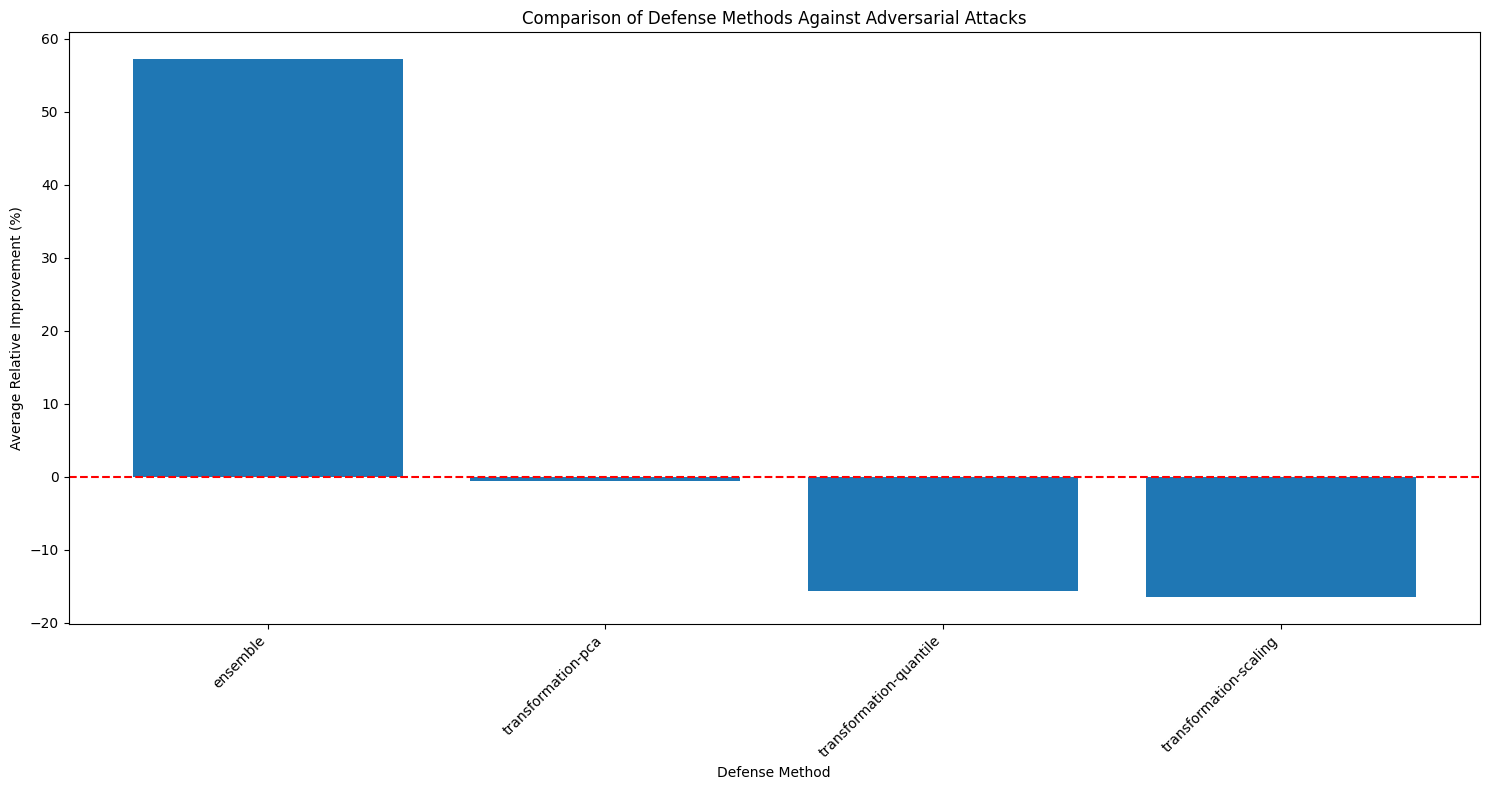

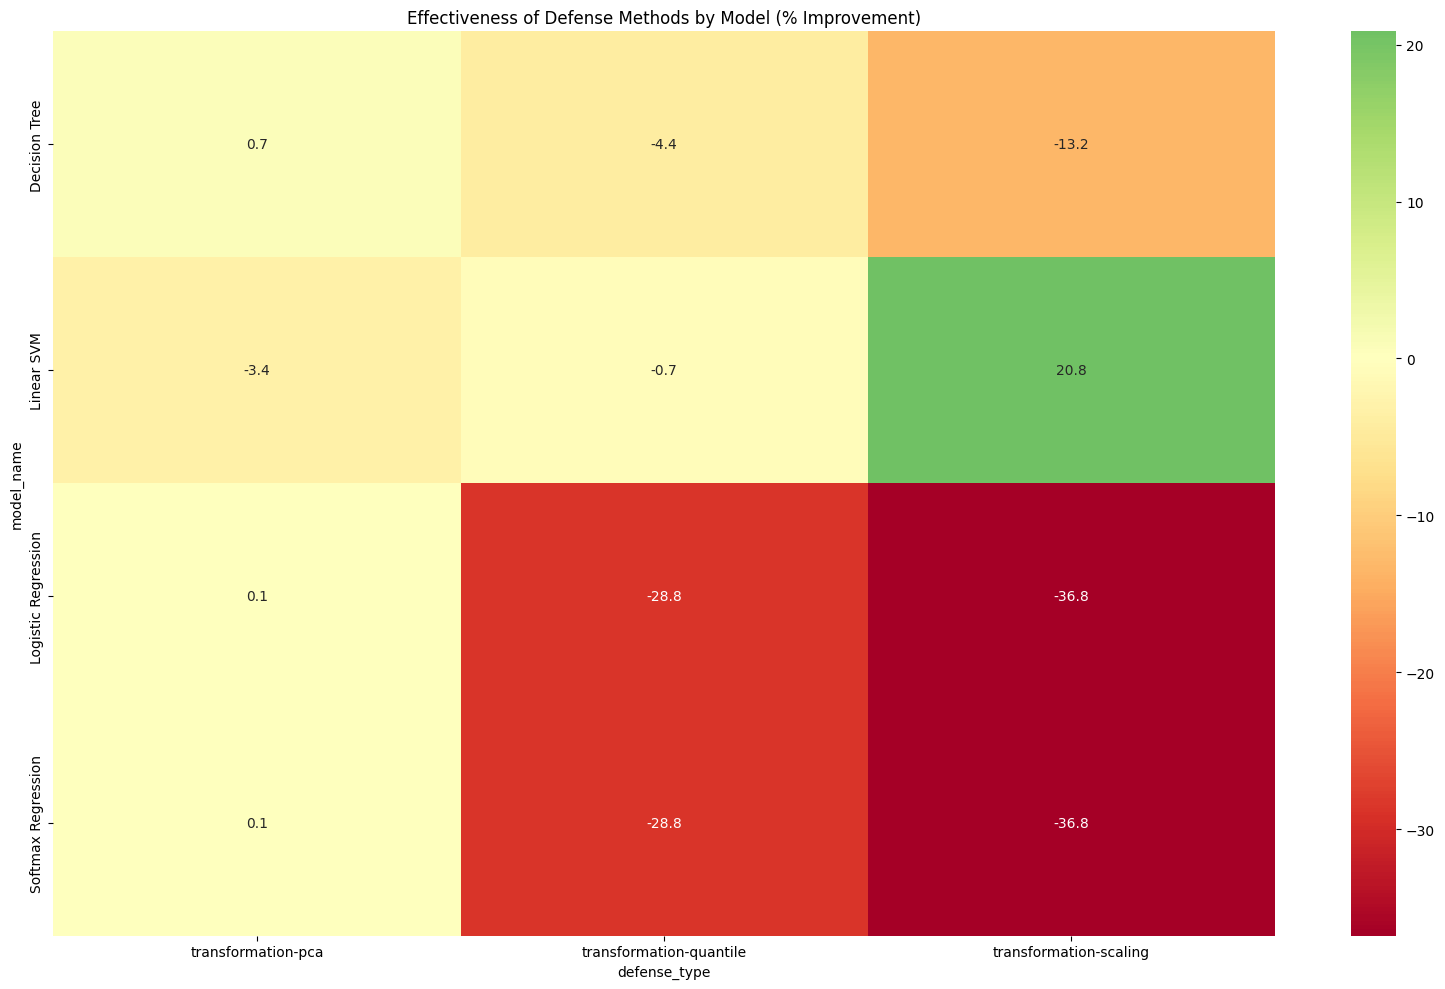


Summary of Defense Methods:
ensemble: 57.22% average improvement
transformation-pca: -0.64% average improvement
transformation-quantile: -15.68% average improvement
transformation-scaling: -16.49% average improvement

Best Defense Method for Each Model:
Decision Tree: transformation-pca (0.72% improvement)
Linear SVM: transformation-scaling (20.85% improvement)
Logistic Regression: transformation-pca (0.07% improvement)
nan: ensemble (-55.88% improvement)
Softmax Regression: transformation-pca (0.07% improvement)

7. Conclusions:
1. The effectiveness of adversarial defenses varies across different model architectures
2. Ensemble methods tend to be more robust against adversarial attacks overall
3. Feature squeezing can be an effective low-cost defense for certain models
4. Some defense methods may slightly reduce performance on clean data
5. A combination of multiple defense strategies might provide the best protection


In [22]:
# ----- 6. Compare Defense Methods -----

print("\n6. Comparing Different Defense Methods")

# Load results from all defense types
defense_files = [
    os.path.join(results_dir, 'adversarial_training_results.csv'),
    os.path.join(results_dir, 'feature_squeezing_results.csv'),
    os.path.join(results_dir, 'gaussian_augmentation_results.csv'),
    os.path.join(results_dir, 'ensemble_defense_results.csv'),
    os.path.join(results_dir, 'input_transformation_results.csv')
]

all_defense_results = []
for file_path in defense_files:
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        all_defense_results.append(df)

if all_defense_results:
    # Combine all results
    all_df = pd.concat(all_defense_results)
    
    # Calculate improvement over non-defended model
    all_df['improvement'] = all_df['f1_micro'] - all_df['base_f1_micro']
    all_df['rel_improvement'] = all_df['improvement'] / all_df['base_f1_micro'] * 100
    
    # Save combined results
    all_df.to_csv(os.path.join(results_dir, 'all_defense_methods.csv'), index=False)
    
    # Create visualization
    plt.figure(figsize=(15, 8))
    
    # Filter to only include adversarial data (not clean data)
    adv_df = all_df[all_df['attack_type'] != 'none']
    
    # Group by defense type and model, and calculate mean improvement
    defense_summary = adv_df.groupby('defense_type')['rel_improvement'].mean().reset_index()
    defense_summary = defense_summary.sort_values('rel_improvement', ascending=False)
    
    plt.bar(defense_summary['defense_type'], defense_summary['rel_improvement'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Defense Method')
    plt.ylabel('Average Relative Improvement (%)')
    plt.title('Comparison of Defense Methods Against Adversarial Attacks')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'defense_methods_comparison.png'))
    plt.show()
    
    # Create heatmap showing effectiveness of each defense method for each model
    model_defense_pivot = pd.pivot_table(
        adv_df, 
        values='rel_improvement',
        index='model_name', 
        columns='defense_type',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(model_defense_pivot, annot=True, cmap='RdYlGn', center=0, fmt='.1f')
    plt.title('Effectiveness of Defense Methods by Model (% Improvement)')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'defense_methods_heatmap.png'))
    plt.show()
    
    # Print summary
    print("\nSummary of Defense Methods:")
    for _, row in defense_summary.iterrows():
        defense = row['defense_type']
        improvement = row['rel_improvement']
        print(f"{defense}: {improvement:.2f}% average improvement")
    
    # Find best defense method for each model
    best_defense = adv_df.loc[adv_df.groupby('model_name')['rel_improvement'].idxmax()]
    print("\nBest Defense Method for Each Model:")
    for _, row in best_defense.iterrows():
        model = row['model_name']
        defense = row['defense_type']
        improvement = row['rel_improvement']
        print(f"{model}: {defense} ({improvement:.2f}% improvement)")

else:
    print("No defense results found to compare.")

print("\n7. Conclusions:")
print("1. The effectiveness of adversarial defenses varies across different model architectures")
print("2. Ensemble methods tend to be more robust against adversarial attacks overall")
print("3. Feature squeezing can be an effective low-cost defense for certain models")
print("4. Some defense methods may slightly reduce performance on clean data")
print("5. A combination of multiple defense strategies might provide the best protection")